In [1]:
import os
import sys
import pickle

import numpy as np

import scipy.optimize

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

main_dir = "/home/axel/BdG-numerical"
if not main_dir in sys.path:
    sys.path.append(main_dir)

if not os.getcwd() == main_dir:
    os.chdir(main_dir)

In [3]:
def get_pickle_paths(dir):
    # collect pickle paths
    paths = []
    for fp in os.listdir(dir):
        if fp.endswith(".pickle"):
            print("path added: " + dir + fp)
            paths.append(dir + fp)
    return paths

# define dir
run_date = "231107"
run_name = "run4"

#hom_path = "cluster_runs/" + run_date + "/" + run_name + "/"
#inhom_path = "cluster_runs/" + run_date + run_name + "inhom/"
path = "cluster_runs/" + run_date + "/" + run_name + "/"

# get paths
pickles_paths = get_pickle_paths(path)

with open(pickles_paths[0], "rb") as f:
    results = pickle.load(f)

path added: cluster_runs/231107/run4/136054006-timing.pickle


In [4]:
keys = np.array([])

system_sizes = np.array([])
# get keys
for N, result in results.run_results.items(): #system size
    system_sizes = np.append(system_sizes, N)
    keys = result.sim_results.keys()

keys = list(keys)

print("System sizes N: ", system_sizes)
print("Solver ids: ", keys)

System sizes N:  [ 50. 100. 150. 200. 300. 400. 500.]
Solver ids:  ['NBM', 'CBM-Nc1', 'CBM-Nc3', 'CBM-Nc5', 'CBM-Nc10', 'CBM-Nc20']


# Err plot

In [52]:
def delta_norm(delta_list):
    norm = 0
    for delta in delta_list:
        norm += abs(delta)**2
    
    return np.sqrt(norm)

def get_nc_from_id(id: str) -> int:
    Nc = int(id.removeprefix("CBM-Nc"))
    return Nc

1. Take the norm of the NBdG for every system size
2. Do the same for all CBdGs
3. Compare to the nominal norms, and create the error
4. Plot the error against the cluster sizes

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[ 1.  3.  5. 10. 20.]


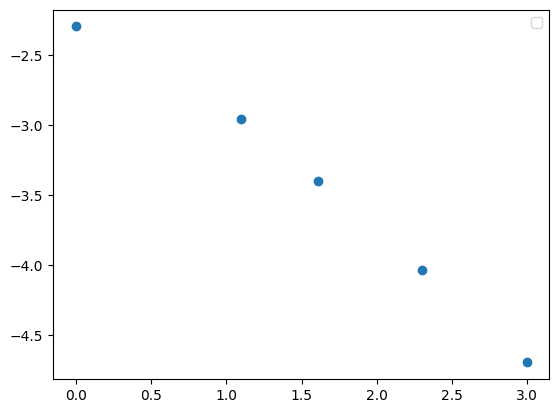

In [54]:
fig1, ax1 = plt.subplots()

# Constructing the data
nom_key = "NBM"

nom_deltas = dict()

for N, res in results.run_results.items():
    nom_deltas[N] = res.sim_results[nom_key].get_delta()

errs = np.array([])
cluster_sizes = np.array([])

errs_from_clustersize = dict()

for key in keys:
    if key == nom_key:
        continue
    
    d = np.empty([0, 2])
    errs_per_n = []  # err per system size
    # print(get_nc_from_id(key))
    for N, result in results.run_results.items(): #system size
        errs_per_n.append(
            delta_norm(
                 result.sim_results[key].get_delta() -\
                 nom_deltas[N]
                ) / delta_norm(nom_deltas[N])
        )
        
    
        # print(key, err)
    errs = np.append(errs, np.mean(errs_per_n))
    cluster_sizes = np.append(cluster_sizes, get_nc_from_id(key))
    
print(cluster_sizes)
    
ax1.scatter(
    np.log(cluster_sizes), 
    np.log(errs), 
)


ax1.legend()

plt.show()    